# Initialization

## Imports

In [2]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
from cbrain.climate_invariant import *

import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
import yaml

## Global Variables

In [3]:
# Load coordinates (just pick any file from the climate model run)

# GP path below
path_0K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/'
coor = xr.open_dataset(path_0K+"AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-09-02-00000.nc")

lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [4]:
path_folRG = '/DFS-L/DATA/pritchard/liranp//To_Tom/Output/'
path_RG0K = path_folRG + 'SST_0001Kp_Neuralnet_SPCAM_all_216/atm/hist/SST_0001Kp_Neuralnet_SPCAM_all_216.cam.h1.2013-'
path_RG0K = path_RG0K + '05-05-*.nc'

coor_RG = xr.open_mfdataset(path_RG0K,decode_cf=False)
latRG = coor_RG.lat; lonRG = coor_RG.lon; levRG = coor_RG.lev;
coor_RG.close();

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from

In [5]:
# GP path below
TRAINDIR = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path = '/export/nfs0home/tbeucler/CBRAIN-CAM/cbrain/'
path_nnconfig = '/export/nfs0home/tbeucler/CBRAIN-CAM/nn_config/'

# Load hyam and hybm to calculate pressure field in SPCAM
path_hyam = 'hyam_hybm.pkl'
hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

# Scale dictionary to convert the loss to W/m2
scale_dict = load_pickle(path_nnconfig+'scale_dicts/009_Wm2_scaling.pkl')

# Table 1: Simulation characteristics

In [6]:
coor_RG['lev'][10]

<xarray.DataArray 'lev' ()>
array(142.99403876)
Coordinates:
    lev      float64 143.0
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

# Table 2: PDF similarity metrics (SJ and Hellinger)

Inspired from [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/044_Climate_invariant_analysis_output_scaling.ipynb]

## Utilities

In [7]:
def Hellinger(x,f,g):
    return np.sqrt(np.trapz(y=0.5*(np.sqrt(f)-np.sqrt(g))**2,x=x))

In [8]:
def KL(x,f,g,eps=1e-6):
    to_integrate = np.copy(f)
    to_integrate[f<eps] = 0
    to_integrate[f>=eps] = f[f>=eps]*np.log(f[f>=eps]/np.maximum(eps,g[f>=eps]))
    return np.trapz(y=to_integrate,x=x)

In [9]:
def JS(x,f,g,eps=1e-6):
    return np.sqrt(0.5*(KL(x,f,g,eps)+KL(x,g,f,eps)))

In [10]:
def maxmin_norm(xf,xg,f,g):
    
    fg_xmax = np.maximum(np.max(xf),np.max(xg))
    fg_xmin = np.minimum(np.min(xf),np.min(xg))
    xf_norm = (xf-fg_xmin)/(fg_xmax-fg_xmin)
    xg_norm = (xg-fg_xmin)/(fg_xmax-fg_xmin)
    
    f_norm = f/np.trapz(x=xf_norm,y=f)
    g_norm = g/np.trapz(x=xg_norm,y=g)
#     fg_max = np.maximum(np.max(f),np.max(g))
#     fg_min = np.minimum(np.min(f),np.min(g))
#     f_norm = (f-fg_min)/(fg_max-fg_min)
#     g_norm = (g-fg_min)/(fg_max-fg_min)
    
    return xf_norm,xg_norm,f_norm,g_norm

In [11]:
# From https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- np ndarrays with the same shape.
    """
    if np.sum(weights)>0:
        average = np.average(values, weights=weights)
        variance = np.average((values-average)**2, weights=weights)
    else: average = np.nan; variance = np.nan
    return (average, np.sqrt(variance))

# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(bin_edges,field_x,field_y):
    # Initialization
    Nbin = np.size(bin_edges)
    Ym = np.zeros((Nbin-1,1))
    Ystd = np.copy(Ym)

    for ibin,edge in enumerate(bin_edges):
        print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
        if ibin>0:
            w = (field_x>=edge_left)*(field_x<edge)
            Ym[ibin-1],Ystd[ibin-1] = weighted_avg_and_std(field_y,w)

        edge_left = edge
    
    return Ym,Ystd

In [12]:
def plot_verthist(S):
    fig, ax = plt.subplots(20,1,figsize=(15,25))

    iav = 0
    JS_mean = 0
    Hel_mean = 0

    for icount,ilev in enumerate(np.arange(10,30)):
        TITLE = 'Hel/JS='
        for idata,data in enumerate(['m4K','ref','p4K']):
            ax[icount].plot(edg2bin(S[ilev][data][1]),S[ilev][data][0],color=COL[idata])
            ax[icount].set_ylabel(str(ilev))

            f_cold = S[ilev]['m4K'][0]; x_cold = edg2bin(S[ilev]['m4K'][1])
            f_data = S[ilev][data][0]; x_data = edg2bin(S[ilev][data][1])

            xf_norm,xg_norm,f_norm,g_norm = maxmin_norm(x_cold,x_data,f_cold,f_data)
            x = np.linspace(0,1,1000)

            f = np.interp(x=x,xp=xf_norm,fp=f_norm)
            g = np.interp(x=x,xp=xg_norm,fp=g_norm)

            H = Hellinger(x,f,g)
            JS0 = JS(x,f,g,eps=1e-4)

            iav += 1
            JS_mean += JS0
            Hel_mean += H

            TITLE += '('+data+') '+str(H)[:5]+'/'+str(JS0)[:5]+' '
        ax[icount].set_title(TITLE)
    fig.tight_layout()
    print('Mean JS is ',str(100*JS_mean/iav),'% and mean Hellinger is ',str(100*Hel_mean/iav),'%')
    
    return JS_mean/iav,Hel_mean/iav

In [13]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

## Load PDFs

In [14]:
path_array = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
     '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
     '2021_06_03_RG_TRAIN_shuffle.nc',
     '2021_04_18_RG_TRAIN_P4K_shuffle.nc',
    #'1','2','3' # dummy paths for HH simulations
]

Load Q

In [15]:
pathPKL = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/PKL_DATA/'

In [16]:
save_name = '2021_06_07_AQUA_RG_Qhist'

In [17]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

Q_data = pickle.load(hf)
hf.close()

Load T

In [18]:
save_name = '2021_06_07_AQUA_RG_Thist'

In [19]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

T_data = pickle.load(hf)
hf.close()

Load T at 200hPa

In [20]:
save_name = '2021_08_18_AQUA_RG_Thist_ilev'+str(12)

In [21]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

T200_data = pickle.load(hf)
hf.close()

Load T at 150hPa

In [22]:
save_name = '2021_08_18_AQUA_RG_Thist_ilev'+str(10)

In [23]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

T150_data = pickle.load(hf)
hf.close()

Load B

In [24]:
path = '2021_06_21_distributions_BMSE'

In [25]:
hf = open(pathPKL+'/'+path+'.pkl','rb')

B_data = pickle.load(hf)
hf.close()

Load LHF

In [26]:
save_name = '2021_06_07_AQUA_RG_LHFhist'

In [27]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

LHF_data = pickle.load(hf)
hf.close()

Load hypohydrostatic histograms

In [28]:
fol_Janni = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/Janni_data/'

In [29]:
Q_data_HH = pickle.load(open(fol_Janni+'q_hists.pkl','rb'))

In [30]:
HHdic = {}
HHdic['QV'] = 'qv';
HHdic['RH'] = 'RH';
HHdic['QfromQsat'] = 'q_deficit'

In [31]:
T_data_HH = pickle.load(open(fol_Janni+'T_hists.pkl','rb'))

In [32]:
T_data_HH['edgQ'].keys()

dict_keys(['Tin', 'BMSE', 'T_mTNS'])

In [33]:
HHdic['T'] = 'Tin'
HHdic['BMSE'] = 'BMSE'
HHdic['TfromNS'] = 'T_mTNS'

In [34]:
T150_data_HH = pickle.load(open(fol_Janni+'T_hists_148hPa.pkl','rb'))

In [35]:
T150_data_HH['edgQ'].keys()

dict_keys(['Tin', 'BMSE', 'T_mTNS'])

Group all variables into the same structure

In [36]:
hisQ = {}
edgQ = {}

for ikey,key in enumerate(['QV','RH','QfromQsat']):
    hisQ[key] = {}
    edgQ[key] = {}
    for ipath,path in enumerate(path_array):
        hisQ[key][path] = {}
        edgQ[key][path] = {}

In [37]:
hisT = {}
edgT = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = {}
        edgT[key][path] = {}

In [38]:
hisT150 = {}
edgT150 = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT150[key] = {}
    edgT150[key] = {}
    for ipath,path in enumerate(path_array):
        hisT150[key][path] = {}
        edgT150[key][path] = {}

In [39]:
hisT200 = {}
edgT200 = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT200[key] = {}
    edgT200[key] = {}
    for ipath,path in enumerate(path_array):
        hisT200[key][path] = {}
        edgT200[key][path] = {}

In [40]:
hisLHF = {}
edgLHF = {}

for ikey,key in enumerate(['LHF','LHF_nsQ','LHF_nsDELQ']):
    hisLHF[key] = {}
    edgLHF[key] = {}
    for ipath,path in enumerate(path_array):
        hisLHF[key][path] = {}
        edgLHF[key][path] = {}

In [41]:
hisQ = Q_data['hisQ']
edgQ = Q_data['edgQ']
# Convert specific humidities to g/kg
for ipath,path0 in enumerate(path_array):
    for ikey,key in enumerate(['QV','QfromQsat']):
        edgQ[key][path0] *= 1e3

In [42]:


hisT = T_data['hisT']
edgT = T_data['edgT']
# Load buoyancy from MSE
ilevB = 23
for ikey,key in enumerate(['BMSE']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = B_data['hisT'][ilevB][path]
        edgT[key][path] = B_data['edgT'][ilevB][path]

hisT200 = T200_data['hisT']
edgT200 = T200_data['edgT']
# Load buoyancy from MSE
ilevB = 12
for ikey,key in enumerate(['BMSE']):
    hisT200[key] = {}
    edgT200[key] = {}
    for ipath,path in enumerate(path_array):
        hisT200[key][path] = B_data['hisT'][ilevB][path]
        edgT200[key][path] = B_data['edgT'][ilevB][path]
        
hisT150 = T150_data['hisT']
edgT150 = T150_data['edgT']
# Load buoyancy from MSE
ilevB = 10
for ikey,key in enumerate(['BMSE']):
    hisT150[key] = {}
    edgT150[key] = {}
    for ipath,path in enumerate(path_array):
        hisT150[key][path] = B_data['hisT'][ilevB][path]
        edgT150[key][path] = B_data['edgT'][ilevB][path]

# Redefine Tarray to replace BCONS with BMSE for now
Tarray = ['T','BMSE','TfromNS']

hisLHF = LHF_data['hisLHF']
edgLHF = LHF_data['edgLHF']

Set histograms to zero for the (-4K) SAM simulations and load Janni values for the other sims

In [43]:
path_array = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
     '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
     '2021_06_03_RG_TRAIN_shuffle.nc',
     '2021_04_18_RG_TRAIN_P4K_shuffle.nc',
    '1','2','3' # dummy paths for HH simulations
]

In [44]:
path_SAM = ['1','2','3']
for ipath,path0 in enumerate(path_SAM):
    
    for ikey,key in enumerate(['QV','RH','QfromQsat']):
        if ipath==2: 
            edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs']
            hisQ[key][path0] = 0*edg2bin(edgQ[key][path0])**0
        elif ipath==0: 
            hisQ[key][path0] = Q_data_HH['hisQ'][HHdic[key]]['qobs']
            if key=='RH': edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs']
            else: edgQ[key][path0] = 1e3*Q_data_HH['edgQ'][HHdic[key]]['qobs'] # Conversion in g/kg
        elif ipath==1: 
            hisQ[key][path0] = Q_data_HH['hisQ'][HHdic[key]]['qobs4K']
            if key=='RH': edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs4K']
            else: edgQ[key][path0] = 1e3*Q_data_HH['edgQ'][HHdic[key]]['qobs4K'] # Conversion in g/kg
    
    for ikey,key in enumerate(['T','BMSE','TfromNS']):
        if ipath==2: 
            edgT[key][path0] = T_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT[key][path0] = 0*edg2bin(edgT[key][path0])**0
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT150[key][path0] = 0*edg2bin(edgT150[key][path0])**0
        elif ipath==0: 
            hisT[key][path0] = T_data_HH['hisQ'][HHdic[key]]['qobs']
            edgT[key][path0] = T_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT150[key][path0] = T150_data_HH['hisQ'][HHdic[key]]['qobs']
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs']
        elif ipath==1: 
            hisT[key][path0] = T_data_HH['hisQ'][HHdic[key]]['qobs4K']
            edgT[key][path0] = T_data_HH['edgQ'][HHdic[key]]['qobs4K']
            hisT150[key][path0] = T150_data_HH['hisQ'][HHdic[key]]['qobs4K']
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs4K']
            
    for ikey,key in enumerate(['LHF','LHF_nsQ','LHF_nsDELQ']):
            edgLHF[key][path0] = np.linspace(0,100,101)
            hisLHF[key][path0] = 0*edg2bin(edgLHF[key][path0])**0

## Calculate JS and Hellinger structures

In [45]:
JS0 = {}; Hel = {};

In [46]:
path_array

['2021_03_18_O3_TRAIN_M4K_shuffle.nc',
 '2021_01_24_O3_TRAIN_shuffle.nc',
 '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
 '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
 '2021_06_03_RG_TRAIN_shuffle.nc',
 '2021_04_18_RG_TRAIN_P4K_shuffle.nc',
 '1',
 '2',
 '3']

### Test with distributions that are as different as possible

One distribution is systematically 0 when the other one is non-zero

In [47]:
x = np.linspace(0,1,1000)

In [48]:
rand_vector = np.random.rand(1000)

In [49]:
f_test = np.zeros((1000,))
f_test[rand_vector>0.5] = 1
f_test /= np.trapz(x=x,y=f_test)

In [50]:
g_test = np.zeros((1000,))
g_test[rand_vector<=0.5] = 1
g_test /= np.trapz(x=x,y=g_test)

In [51]:
H_test = Hellinger(x,f_test,g_test)

In [52]:
H_test

1.0

In [53]:
JS_test = JS(x,f_test,g_test)

In [54]:
JS_test

3.8092297584814916

### Test with calculated distributions

In [55]:
fsave = {}; gsave = {}; 

In [56]:
for ivar,var in enumerate(['QV','T','T200','T150','LHF']):
    print('var=',var,end='\n')
    JS0[var] = {}; Hel[var] = {}; fsave[var] = {}; gsave[var] = {};
    if var=='QV': key_array = ['QV','RH','QfromQsat']; edg = edgQ; his = hisQ;
    elif var=='T': key_array = ['T','BMSE','TfromNS']; edg = edgT; his = hisT;
    elif var=='T200': edg = edgT200; his = hisT200;
    elif var=='T150': edg = edgT150; his = hisT150;
    elif var=='LHF': key_array = ['LHF','LHF_nsQ','LHF_nsDELQ']; edg = edgLHF; his  = hisLHF;
        
    for ikey,key in enumerate(key_array):
        print('key=',key,'                   ',end='\r')
        JS0[var][key] = {}; Hel[var][key] = {};
        fsave[var][key] = {}; gsave[var][key] = {};
        
        for ipath,path in enumerate(path_array):
            
            if ipath<3: 
                f_cold = his[key][path_array[0]]
                x_cold = edg2bin(edg[key][path_array[0]])
            else:
                f_cold = his[key][path_array[3]]
                x_cold = edg2bin(edg[key][path_array[3]])
            
            f_data = his[key][path]; x_data = edg2bin(edg[key][path])

            xf_norm,xg_norm,f_norm,g_norm = maxmin_norm(x_cold,x_data,f_cold,f_data)
            x = np.linspace(0,1,1000)
            
            f = np.interp(x=x,xp=xf_norm,fp=f_norm)
            g = np.interp(x=x,xp=xg_norm,fp=g_norm)
            
            f = np.maximum(f,0); f /= np.trapz(x=x,y=f)
            g = np.maximum(g,0); g /= np.trapz(x=x,y=g)

            fsave[var][key][path] = f
            gsave[var][key][path] = g
            
            Hel[var][key][path] = Hellinger(x,f,g)
            JS0[var][key][path] = JS(x,f,g)
            
        if ikey==0: stop

var= QV


/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


NameError: name 'stop' is not defined

In [ ]:
JS0[var][key][path]

In [ ]:
print(key,path,np.sum(fsave[var][key][path]>0));

QV 3 1000


In [ ]:
g

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [ ]:
var

'QV'

In [ ]:
key

'QV'

In [ ]:
path

'3'

In [ ]:
xg_norm

array([0.00000000e+00, 9.21110131e-06, 1.84222044e-05, 2.76333067e-05,
       3.68444125e-05, 4.60555166e-05, 5.52666170e-05, 6.44777174e-05,
       7.36888178e-05, 8.28999327e-05, 9.21110332e-05, 1.01322134e-04,
       1.10533234e-04, 1.19744334e-04, 1.28955449e-04, 1.38166535e-04,
       1.47377650e-04, 1.56588736e-04, 1.65799865e-04, 1.75010951e-04,
       1.84222066e-04, 1.93433152e-04, 2.02644267e-04, 2.11855353e-04,
       2.21066468e-04, 2.30277554e-04, 2.39488669e-04, 2.48699769e-04,
       2.57910870e-04, 2.67121970e-04, 2.76333070e-04, 2.85544200e-04,
       2.94755271e-04, 3.03966401e-04, 3.13177472e-04, 3.22388601e-04,
       3.31599731e-04, 3.40810802e-04, 3.50021903e-04, 3.59233003e-04,
       3.68444133e-04, 3.77655204e-04, 3.86866304e-04, 3.96077405e-04,
       4.05288534e-04, 4.14499606e-04, 4.23710735e-04, 4.32921835e-04,
       4.42132936e-04, 4.51344065e-04, 4.60555137e-04, 4.69766237e-04,
       4.78977337e-04, 4.88188467e-04, 4.97399538e-04, 5.06610610e-04,
      

1.0000000000000002
nan


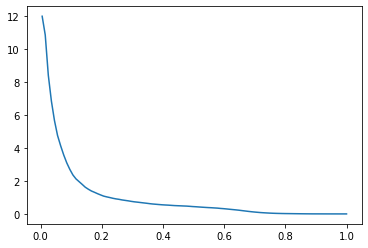

In [ ]:
plt.plot(xf_norm,f_norm)
plt.plot(xg_norm,g_norm,color='r')
print(np.trapz(x=xf_norm,y=f_norm))
print(np.trapz(x=xg_norm,y=g_norm))

1.0
nan


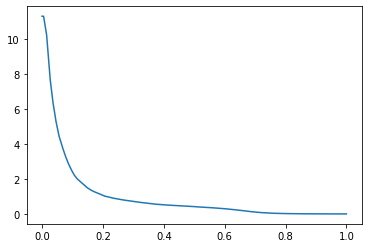

In [ ]:
plt.plot(x,f)
plt.plot(x,g,color='r')
print(np.trapz(x=x,y=f))
print(np.trapz(x=x,y=g))

### Full calculation

In [ ]:
for ivar,var in enumerate(['QV','T','T200','T150','LHF']):
    print('var=',var,end='\n')
    JS0[var] = {}; Hel[var] = {}; fsave[var] = {}; gsave[var] = {};
    if var=='QV': key_array = ['QV','RH','QfromQsat']; edg = edgQ; his = hisQ;
    elif var=='T': key_array = ['T','BMSE','TfromNS']; edg = edgT; his = hisT;
    #elif var=='T200': edg = edgT200; his = hisT200;
    elif var=='T150': edg = edgT150; his = hisT150;
    elif var=='LHF': key_array = ['LHF','LHF_nsQ','LHF_nsDELQ']; edg = edgLHF; his  = hisLHF;
        
    for ikey,key in enumerate(key_array):
        print('key=',key,'                   ',end='\r')
        JS0[var][key] = {}; Hel[var][key] = {};
        fsave[var][key] = {}; gsave[var][key] = {};
        
        for ipath,path in enumerate(path_array):
            
            if ipath<3: 
                f_cold = his[key][path_array[0]]
                x_cold = edg2bin(edg[key][path_array[0]])
            elif ipath<6:
                f_cold = his[key][path_array[3]]
                x_cold = edg2bin(edg[key][path_array[3]])
            else:
                f_cold = his[key][path_array[6]]
                x_cold = edg2bin(edg[key][path_array[6]])
            
            f_data = his[key][path]; x_data = edg2bin(edg[key][path])

            xf_norm,xg_norm,f_norm,g_norm = maxmin_norm(x_cold,x_data,f_cold,f_data)
            x = np.linspace(0,1,1000)
            
            f = np.interp(x=x,xp=xf_norm,fp=f_norm)
            g = np.interp(x=x,xp=xg_norm,fp=g_norm)
            
            f = np.maximum(f,0); f /= np.trapz(x=x,y=f)
            g = np.maximum(g,0); g /= np.trapz(x=x,y=g)

            fsave[var][key][path] = f
            gsave[var][key][path] = g
            
            Hel[var][key][path] = Hellinger(x,f,g)
            JS0[var][key][path] = JS(x,f,g)

var= QV
key= QV                    
key= RH                    
key= QfromQsat                    
var= T
key= T                    
key= BMSE                    
key= TfromNS                    
var= T200
key= T                    
key= BMSE                    
key= TfromNS                    
var= T150
key= T                    
key= BMSE                    
key= TfromNS                    
var= LHF
key= LHF                    
key= LHF_nsQ                    


/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
JS0,Hel

({'QV': {'QV': {'2021_03_18_O3_TRAIN_M4K_shuffle.nc': 0.0,
    '2021_01_24_O3_TRAIN_shuffle.nc': 0.4940237392448798,
    '2021_03_18_O3_TRAIN_P4K_shuffle.nc': 0.8284298622895779,
    '2021_04_18_RG_TRAIN_M4K_shuffle.nc': 0.0,
    '2021_06_03_RG_TRAIN_shuffle.nc': 0.3916983009148076,
    '2021_04_18_RG_TRAIN_P4K_shuffle.nc': 0.7484382082686006,
    '1': 0.0,
    '2': 0.536699050209215,
    '3': nan},
   'RH': {'2021_03_18_O3_TRAIN_M4K_shuffle.nc': 0.0,
    '2021_01_24_O3_TRAIN_shuffle.nc': 0.07179247478514078,
    '2021_03_18_O3_TRAIN_P4K_shuffle.nc': 0.16390965009077263,
    '2021_04_18_RG_TRAIN_M4K_shuffle.nc': 0.0,
    '2021_06_03_RG_TRAIN_shuffle.nc': 0.06472217008563089,
    '2021_04_18_RG_TRAIN_P4K_shuffle.nc': 0.1070446135677093,
    '1': 0.0,
    '2': 0.0867269137540327,
    '3': nan},
   'QfromQsat': {'2021_03_18_O3_TRAIN_M4K_shuffle.nc': 0.0,
    '2021_01_24_O3_TRAIN_shuffle.nc': 0.685671822164562,
    '2021_03_18_O3_TRAIN_P4K_shuffle.nc': 1.0116753618051118,
    '2021_04_18_R

## Table code in latex

In [ ]:
TABLEname = 'Hellinger'
if TABLEname=='JS': Name = 'Jensen-Shannon'; Unit = ''; fac = 1;
elif TABLEname=='Hellinger': Name = 'Hellinger'; Unit = '(in $\\%$)'; fac = 100;
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
VAR = ['QV','T','T150','LHF']
topline = "Row & Input & SPCAM3 & SPCAM5 & SAM\\tabularnewline\n"
caption = Name+" distance "+Unit+" away from the (-4K) simulation for "+\
"the PDFs of $\\left(q_{600\mathrm{hPa}},T_{850\mathrm{hPa}},T_{150\mathrm{hPa}},"+\
"\\mathrm{LHF}\\right)$ and their rescalings: (+0K) distance in gray and (+4K) distance in red." 

In [ ]:
if TABLEname=='JS': S = JS0
elif TABLEname=='Hellinger': S = Hel

In [ ]:
f= open(path,"w+")
f.write("\\begin{table}\n")
f.write("\\begin{centering}\n")
f.write("\\begin{tabular}{c|c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
irow = 0
for ivar,var in enumerate(VAR):
    f.write("\\hline\n")
    if var=='QV': 
        key_array = ['QV','QfromQsat','RH']; 
        tex_array = ['$q_{600\\mathrm{hPa}}$','$q_{\\mathrm{deficit,}600\\mathrm{hPa}}$',
                     '$\mathrm{RH}_{600\\mathrm{hPa}}$']
    elif var=='T': 
        key_array = ['T','TfromNS','BMSE'];
        tex_array = ['$T_{850\\mathrm{hPa}}$',
                     '$T_{\\mathrm{from\\ NS},850\mathrm{hPa}}$',
                     '$B_{\\mathrm{plume},850\\mathrm{hPa}}$']
    elif var=='T150':
        tex_array = ['$T_{150\\mathrm{hPa}}$',
                     '$T_{\\mathrm{from\\ NS},150\\mathrm{hPa}}$',
                     '$B_{\\mathrm{plume},150\\mathrm{hPa}}$']
    elif var=='LHF': 
        key_array = ['LHF','LHF_nsQ','LHF_nsDELQ'];
        tex_array = ['$\\mathrm{LHF}$','$\\mathrm{LHF}_{q}$',
                     '$\\mathrm{LHF}_{\\Delta q}$']
    for ikey,key in enumerate(key_array):
        irow += 1
        f.write(str(irow)+" & ")
        f.write(tex_array[ikey]+" & ")
        f.write("\\textcolor{gray}{")
        f.write("%2.1f"%(fac*S[var][key][path_array[1]]))
        f.write("}, \\textcolor{red}{")
        f.write("%2.1f"%(fac*S[var][key][path_array[2]]))
        f.write("} & \\textcolor{gray}{")
        f.write("%2.1f"%(fac*S[var][key][path_array[4]]))
        f.write("}, \\textcolor{red}{")
        f.write("%2.1f"%(fac*S[var][key][path_array[5]]))
        f.write("} & \\textcolor{gray}{")
        if var!='LHF':
            f.write("%2.1f"%(fac*S[var][key][path_array[7]]))
        f.write("} \\tabularnewline")
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\label{tab:PDF}\n")
f.write("\\end{table}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table Hellinger printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/Hellinger.txt


# Table 3: MSE of different MLRs/NNs

Inspired from [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/073_CI_Results_Figure.ipynb]

## Load data

In [57]:
path_PKL = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/PKL_DATA/'
epoch = np.arange(1,21)

### Trained on ref climate

In [58]:
path_MLR_BF = path_PKL + 'PKL_DATA2021_04_26_MLR_hist.pkl'
hf = open(path_MLR_BF,'rb')
hist_MLR_BF = pickle.load(hf)
hist_MLR_BF = hist_MLR_BF['hist']

In [59]:
path_NN_BF1 = path_PKL + 'PKL_DATA2021_04_26_NN_hist.pkl'
path_NN_BF2 = path_PKL + 'PKL_DATA2021_05_04_NN_hist.pkl'

hf = open(path_NN_BF1,'rb')
hist_NN_BF1 = pickle.load(hf)
hist_NN_BF1 = hist_NN_BF1['hist']

hf = open(path_NN_BF2,'rb')
hist_NN_BF2 = pickle.load(hf)
hist_NN_BF2 = hist_NN_BF2['hist']

In [60]:
hist_NN_BF = {}
for ikey,key in enumerate(hist_NN_BF1.keys()):
    hist_NN_BF[key] = 0.5*(np.array(hist_NN_BF1[key])+np.array(hist_NN_BF2[key]))

In [61]:
path_MLR_BMSE = path_PKL + 'PKL_DATA2021_06_17_MLR_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_BMSE,'rb')
hist_MLR_BMSE = pickle.load(hf)
hist_MLR_BMSE = hist_MLR_BMSE['hist']

In [62]:
path_MLR_TfromNS = path_PKL + 'PKL_DATA2021_04_26_MLR_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_TfromNS,'rb')
hist_MLR_TfromNS = pickle.load(hf)
hist_MLR_TfromNS = hist_MLR_TfromNS['hist']

In [63]:
path_NN_TfromNS = path_PKL + 'PKL_DATA2021_04_26_NN_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_TfromNS,'rb')
hist_NN_TfromNS = pickle.load(hf)
hist_NN_TfromNS = hist_NN_TfromNS['hist']

In [64]:
path_NN_BMSE = path_PKL + 'PKL_DATA2021_06_17_NN_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_BMSE,'rb')
hist_NN_BMSE = pickle.load(hf)
hist_NN_BMSE = hist_NN_BMSE['hist']

### Warm to cold

In [65]:
path_MLR_BF_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_MLR_hist.pkl'
hf = open(path_MLR_BF_W2C,'rb')
hist_MLR_BF_W2C = pickle.load(hf)
hist_MLR_BF_W2C = hist_MLR_BF_W2C['hist']

In [66]:
path_NN_BF_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_NN_hist.pkl'
hf = open(path_NN_BF_W2C,'rb')
hist_NN_BF_W2C = pickle.load(hf)
hist_NN_BF_W2C = hist_NN_BF_W2C['hist']

In [67]:
path_MLR_BMSE_W2C = path_PKL + 'PKL_DATA2021_06_17_W2C_MLR_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_BMSE_W2C,'rb')
hist_MLR_BMSE_W2C = pickle.load(hf)
hist_MLR_BMSE_W2C = hist_MLR_BMSE_W2C['hist']

In [68]:
path_NN_BMSE_W2C = path_PKL + 'PKL_DATA2021_06_17_W2C_NN_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_BMSE_W2C,'rb')
hist_NN_BMSE_W2C = pickle.load(hf)
hist_NN_BMSE_W2C = hist_NN_BMSE_W2C['hist']

In [69]:
path_MLR_TfromNS_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_MLR_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_TfromNS_W2C,'rb')
hist_MLR_TfromNS_W2C = pickle.load(hf)
hist_MLR_TfromNS_W2C = hist_MLR_TfromNS_W2C['hist']

In [70]:
path_NN_TfromNS_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_NN_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_TfromNS_W2C,'rb')
hist_NN_TfromNS_W2C = pickle.load(hf)
hist_NN_TfromNS_W2C = hist_NN_TfromNS_W2C['hist']

### RG to aquaplanet

In [71]:
path_MLR_BF_RG2AQ = path_PKL + 'PKL_DATA2021_06_03_RG2AQ_MLR_hist.pkl'
hf = open(path_MLR_BF_RG2AQ,'rb')
hist_MLR_BF_RG2AQ = pickle.load(hf)
hist_MLR_BF_RG2AQ = hist_MLR_BF_RG2AQ['hist']

In [72]:
path_NN_BF_RG2AQ = path_PKL + 'PKL_DATA2021_06_03_RG2AQ_NN_hist.pkl'
hf = open(path_NN_BF_RG2AQ,'rb')
hist_NN_BF_RG2AQ = pickle.load(hf)
hist_NN_BF_RG2AQ = hist_NN_BF_RG2AQ['hist']

In [73]:
path_MLR_BMSE_RG2AQ = path_PKL + 'PKL_DATA2021_06_17_RG2AQ_MLR_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_BMSE_RG2AQ,'rb')
hist_MLR_BMSE_RG2AQ = pickle.load(hf)
hist_MLR_BMSE_RG2AQ = hist_MLR_BMSE_RG2AQ['hist']

In [74]:
path_NN_BMSE_RG2AQ = path_PKL + 'PKL_DATA2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_BMSE_RG2AQ,'rb')
hist_NN_BMSE_RG2AQ = pickle.load(hf)
hist_NN_BMSE_RG2AQ = hist_NN_BMSE_RG2AQ['hist']

### Batch normalization & dropout

Climate-invariant

In [75]:
path_CI_DPBN = path_PKL+'PKL_DATA2021_08_03_NN_RH_BMSE_LHF_nsDELQ_Dropout30_BNL1_hist.pkl'
hf = open(path_CI_DPBN,'rb')
hist_CI_DPBN = pickle.load(hf)
hist_CI_DPBN = hist_CI_DPBN['hist']

In [76]:
path_CI_DPBN_W2C = path_PKL+'PKL_DATA2021_08_05_W2C_NN_RH_BMSE_LHF_nsDELQ_BNL1_Dropout30_hist.pkl'
hf = open(path_CI_DPBN_W2C,'rb')
hist_CI_DPBN_W2C = pickle.load(hf)
hist_CI_DPBN_W2C = hist_CI_DPBN_W2C['hist']

In [77]:
path_CI_DPBN_RG2AQ = path_PKL+'PKL_DATA2021_08_07_RG2AQ_NN_RH_BMSE_LHF_nsDELQ_BNL1_Dropout30_hist.pkl'
hf = open(path_CI_DPBN_RG2AQ,'rb')
hist_CI_DPBN_RG2AQ = pickle.load(hf)
hist_CI_DPBN_RG2AQ = hist_CI_DPBN_RG2AQ['hist'] 

Brute-force

In [78]:
path_BF_DPBN = path_PKL+'PKL_DATA2021_08_08_NN_BNL1_Dropout30_hist.pkl'
hf = open(path_BF_DPBN,'rb')
hist_BF_DPBN = pickle.load(hf)
hist_BF_DPBN = hist_BF_DPBN['hist']

In [79]:
path_BF_DPBN_W2C = path_PKL+'PKL_DATA2021_08_08_W2C_NN_BNL1_DP30_hist.pkl'
hf = open(path_BF_DPBN_W2C,'rb')
hist_BF_DPBN_W2C = pickle.load(hf)
hist_BF_DPBN_W2C = hist_BF_DPBN_W2C['hist']

In [80]:
path_BF_DPBN_RG2AQ = path_PKL+'PKL_DATA2021_08_09_RG2AQ_NN_BNL1_DP30_hist.pkl'
hf = open(path_BF_DPBN_RG2AQ,'rb')
hist_BF_DPBN_RG2AQ = pickle.load(hf)
hist_BF_DPBN_RG2AQ = hist_BF_DPBN_RG2AQ['hist'] 

## Create Table structure

In [86]:
MSE_array = np.zeros((3,2,6,4)) # Training sets x Best/5best x Models x Test sets

In [87]:
for itraining in range(3):
    for imodel in range(6):
        for itest in range(4):
        
            if itraining==0:
                if imodel==0: h = hist_MLR_BF; k = ['loss', 'val_loss', 'trainP4K_loss', 'trainM4K_RG_loss']
                elif imodel==1: h = hist_MLR_BMSE;
                elif imodel==2: h = hist_NN_BF;
                elif imodel==3: h = hist_BF_DPBN;
                elif imodel==4: h = hist_NN_BMSE;
                elif imodel==5: h = hist_CI_DPBN;
            elif itraining==1:
                if imodel==0: h = hist_MLR_BF_W2C; k = ['loss', 'val_loss', 'trainM4K_loss', 'trainP4K_RG_loss']
                elif imodel==1: h = hist_MLR_BMSE_W2C;
                elif imodel==2: h = hist_NN_BF_W2C;
                elif imodel==3: h = hist_BF_DPBN_W2C;
                elif imodel==4: h = hist_NN_BMSE_W2C;
                elif imodel==5: h = hist_CI_DPBN_W2C;
            elif itraining==2:
                if imodel==0: h = hist_MLR_BF_RG2AQ; k = ['loss', 'val_loss', 'trainM4K_loss', 'trainP4K_RG_loss']
                elif imodel==1: h = hist_MLR_BMSE_RG2AQ;
                elif imodel==2: h = hist_NN_BF_RG2AQ;
                elif imodel==3: h = hist_BF_DPBN_RG2AQ;
                elif imodel==4: h = hist_NN_BMSE_RG2AQ;
                elif imodel==5: h = hist_CI_DPBN_RG2AQ;
                 
            sortI = np.argsort(h[k[itest]])
            MSE_array[itraining,0,imodel,itest] = h[k[itest]][sortI[0]]
            hav = 0
            for iav in range(5):
                hav += h[k[itest]][sortI[iav]]/5
            MSE_array[itraining,1,imodel,itest] = hav 

In [90]:
NORMMSE_array = np.zeros((3,6,4)) # Training sets x Models x Test sets

In [92]:
for itraining in range(3):
    for imodel in range(6):
        for itest in range(4):
            NORMMSE_array[itraining,imodel,itest] = MSE_array[itraining,0,imodel,itest]/MSE_array[itraining,0,0,itest]

## Table code in latex

In [84]:
TABLEname = 'CI_Paper_Results'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
path = path_TXT+TABLEname+".txt"

topline1 = " & & Training Set & \\textbf{Validation Set} & Training Set & Training Set\\tabularnewline\n"
topline2 = "Trained & Model & Same temperature & Same temperature & \\textbf{Different temperature} & Same temperature\\tabularnewline\n"
topline3 = "on & & Same geography & Same geography & Same geography & \\textbf{Different geography}\\tabularnewline\n"

caption = "Mean-Squared Error (MSE, in units W$^{2}$ m$^{-4}$) of six models trained in three simulations (first column)"+\
" and evaluated over the training or validation set of the same and two other simulations (last four columns)."+\
" The models (second column) are brute-force (BF) or climate-invariant (CI), multiple linear regressions (MLR) "+\
"or neural nets (NN), and sometimes include dropout layers preceded by a batch normalization layer (DN)."+\
" The models are trained for 20 epochs and we give the MSE corresponding to the epoch of minimal validation loss"+\
" followed by the MSE averaged over the 5 epochs with lowest validation losses (in parentheses)."

COLOR = ['black','purple','black','teal','purple','teal']
MODEL = [[" & MLR BF",
          "\\textcolor{blue}{Cold} & \\textcolor{purple}{MLR CI}",
          "\\textcolor{blue}{Aquaplanet} & NN BF",
          "\\textcolor{blue}{(-4K)} & \\textcolor{teal}{NN BF+DN}",
          "SPCAM3 & \\textcolor{purple}{NN CI}",
          " & \\textcolor{teal}{NN CI+DN}"],
         [" & MLR BF",
          "\\textcolor{red}{Warm} & \\textcolor{purple}{MLR CI}",
          "\\textcolor{red}{Aquaplanet} & NN BF",
          "\\textcolor{red}{(+4K)} & \\textcolor{teal}{NN BF+DN}",
          "SPCAM3 & \\textcolor{purple}{NN CI}",
          " & \\textcolor{teal}{NN CI+DN}"],
         [" & MLR BF",
          "\\textcolor{green}{Cold} & \\textcolor{purple}{MLR CI}",
          "\\textcolor{green}{Earth-like} & NN BF",
          "\\textcolor{green}{(-4K)} & \\textcolor{teal}{NN BF+DN}",
          "SPCAM5 & \\textcolor{purple}{NN CI}",
          " & \\textcolor{teal}{NN CI+DN}"]]

In [ ]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("\\begin{tabular}{c|c||c|c|c|c}\n")
f.write(topline1)
f.write(topline2)
f.write(topline3)
for itrain in range(3):
    f.write("\\hline\n")
    for imodel in range(6):
        f.write(MODEL[itrain][imodel])
        for itest in range(4):
            f.write(" & ")
            f.write("\\textcolor{"+COLOR[imodel]+"}{")
            f.write("%3.0f"%MSE_array[itrain,0,imodel,itest]+" ")
            f.write("("+"%3.0f"%MSE_array[itrain,1,imodel,itest]+") ")
            f.write("}")
        f.write("\\tabularnewline\n")
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\label{tab:Results}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table CI_Paper_Results printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/CI_Paper_Results.txt


## Revised Table taking raw-data multiple linear regression as a reference

In [93]:
TABLEname = 'CI_Paper_Results_Revised'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
path = path_TXT+TABLEname+".txt"

topline1 = " & & Training Set & \\textbf{Validation Set} & Training Set & Training Set\\tabularnewline\n"
topline2 = "Trained & Model & Same temperature & Same temperature & \\textbf{Different temperature} & Same temperature\\tabularnewline\n"
topline3 = "on & & Same configuration & Same configuration & Same configuration & \\textbf{Different configuration}\\tabularnewline\n"

caption = "Mean-Squared Error (MSE, in units W$^{2}$ m$^{-4}$) of six models trained in three simulations (first column) and evaluated over the training or validation set of the same and two other simulations (last four columns). The models (second column) are raw-data (RD) or climate-invariant (CI), multiple linear regressions (MLR) or neural nets (NN), and sometimes include dropout layers preceded by a batch normalization layer (DN). The models are trained for 20 epochs and we give the MSE corresponding to the epoch of minimal validation loss followed by the MSE averaged over the 5 epochs with lowest validation losses (in parentheses). Note that ``Different Temperature'' refers to (+4K) for (-4K) training sets and vice versa. In each application case, we highlight the best model's error using bold font."

COLOR = ['black','purple','black','teal','purple','teal']
MODEL = [[" & MLR BF",
          "\\textcolor{blue}{Cold} & \\textcolor{purple}{MLR CI}",
          "\\textcolor{blue}{Aquaplanet} & NN BF",
          "\\textcolor{blue}{(-4K)} & \\textcolor{teal}{NN BF+DN}",
          "SPCAM3 & \\textcolor{purple}{NN CI}",
          " & \\textcolor{teal}{NN CI+DN}"],
         [" & MLR BF",
          "\\textcolor{red}{Warm} & \\textcolor{purple}{MLR CI}",
          "\\textcolor{red}{Aquaplanet} & NN BF",
          "\\textcolor{red}{(+4K)} & \\textcolor{teal}{NN BF+DN}",
          "SPCAM3 & \\textcolor{purple}{NN CI}",
          " & \\textcolor{teal}{NN CI+DN}"],
         [" & MLR BF",
          "\\textcolor{green}{Cold} & \\textcolor{purple}{MLR CI}",
          "\\textcolor{green}{Earth-like} & NN BF",
          "\\textcolor{green}{(-4K)} & \\textcolor{teal}{NN BF+DN}",
          "SPCAM5 & \\textcolor{purple}{NN CI}",
          " & \\textcolor{teal}{NN CI+DN}"]]

In [94]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("\\begin{tabular}{c|c||c|c|c|c}\n")
f.write(topline1)
f.write(topline2)
f.write(topline3)
for itrain in range(3):
    f.write("\\hline\n")
    for imodel in range(6):
        f.write(MODEL[itrain][imodel])
        for itest in range(4):
            f.write(" & ")
            f.write("\\textcolor{"+COLOR[imodel]+"}{")
            f.write("%3.0f"%MSE_array[itrain,0,imodel,itest]+" ")
            f.write("("+"%3.0f"%MSE_array[itrain,1,imodel,itest]+") ")
            f.write(", "+"%1.1f"%NORMMSE_array[itrain,imodel,itest])
            f.write("}")
        f.write("\\tabularnewline\n")
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\label{tab:Results}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table CI_Paper_Results_Revised printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/CI_Paper_Results_Revised.txt
